In [ ]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model
import os

In [ ]:
# Load dataset
def load_data():
    file_path = "/content/cleaned1_thailand_foods.csv"
    df = pd.read_csv(file_path)
    df["ingredients"] = df["ingredients"].apply(literal_eval)
    df["ingredient_text"] = df["ingredients"].apply(lambda ing: " ".join(ing))
    return df

df = load_data()


In [ ]:
@register_keras_serializable()
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention = Dense(1, activation='tanh')

    def call(self, inputs):
        weights = self.attention(inputs)
        weights = tf.nn.softmax(weights, axis=1)
        return tf.reduce_sum(inputs * weights, axis=1)


In [ ]:
# Tokenize ingredients
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["ingredient_text"])
sequences = tokenizer.texts_to_sequences(df["ingredient_text"])
max_len = max(map(len, sequences))
x_data = pad_sequences(sequences, maxlen=max_len)

# Define the attention layer outside the attention_mechanism function
attention_layer = Dense(1, activation='tanh') # Define attention layer here

@register_keras_serializable()
def attention_mechanism(inputs):
    # Use the pre-defined attention layer
    weights = attention_layer(inputs)
    weights = tf.nn.softmax(weights, axis=1)
    return tf.reduce_sum(inputs * weights, axis=1)

@register_keras_serializable()
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def create_siamese_model(vocab_size, embedding_dim=128, lstm_units=64):
    input_a = Input(shape=(max_len,))
    input_b = Input(shape=(max_len,))

    embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)
    lstm = LSTM(lstm_units, return_sequences=True)

    encoded_a = lstm(embedding(input_a))
    encoded_b = lstm(embedding(input_b))

    attention_layer = AttentionLayer()

    encoded_a = attention_layer(encoded_a)
    encoded_b = attention_layer(encoded_b)

    distance = Lambda(euclidean_distance)([encoded_a, encoded_b])
    output = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
    return model


In [ ]:
# Create and compile the model
vocab_size = len(tokenizer.word_index) + 1
siamese_model = create_siamese_model(vocab_size)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train/Test Split
x_train, x_test = train_test_split(x_data, test_size=0.2, random_state=42)

In [ ]:
# Generate pairs for training
def generate_pairs(x_data):
    pairs = []
    labels = []
    for i in range(len(x_data)):
        for j in range(len(x_data)):
            if i != j:
                pairs.append([x_data[i], x_data[j]])
                labels.append(1 if df.iloc[i]['course'] == df.iloc[j]['course'] else 0)
    return np.array(pairs), np.array(labels)

In [ ]:
siamese_model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_29            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 9, 128)         │         22,016 │ input_layer_28[0][0],  │
│                           │                        │                │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 9, 64)          │         49,408 │ embedding_14[0][0],    │
│                           │                        │                │ embedding_14[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer_14        │ (None, 64)             │             65 │ lstm_14[0][0],         │
│ (AttentionLayer)          │                        │                │ lstm_14[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_14 (Lambda)        │ (None, 1)              │              0 │ attention_layer_14[0]… │
│                           │                        │                │ attention_layer_14[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 1)              │              2 │ lambda_14[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 71,491 (279.26 KB)

 Trainable params: 71,491 (279.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
pairs, labels = generate_pairs(x_train)
pairs = [pairs[:, 0], pairs[:, 1]]

# Train the model and record history
history = siamese_model.fit(pairs, labels, batch_size=64, epochs=15, validation_split=0.1)

Epoch 1/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6165 - loss: 0.6540 - val_accuracy: 0.6779 - val_loss: 0.5988
Epoch 2/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8424 - loss: 0.5034 - val_accuracy: 0.6932 - val_loss: 0.5041
Epoch 3/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8735 - loss: 0.4356 - val_accuracy: 0.6928 - val_loss: 0.5050
Epoch 4/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8764 - loss: 0.3921 - val_accuracy: 0.7283 - val_loss: 0.4783
Epoch 5/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8813 - loss: 0.3627 - val_accuracy: 0.7740 - val_loss: 0.4555
Epoch 6/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8893 - loss: 0.3388 - val_accuracy: 0.7629 - val_loss: 0.4619
Epoch 7/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8908 - loss: 0.3194 - val_accuracy: 0.8168 - val_loss: 0.4288
Epoch 8/15
606/606 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8946 - loss: 0.2991 - val_accurac

In [ ]:
# Save the model
model_path = "siamese_food_recommendation_model.h5"
siamese_model.save(model_path)
# model = load_model(model_path comile = False)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


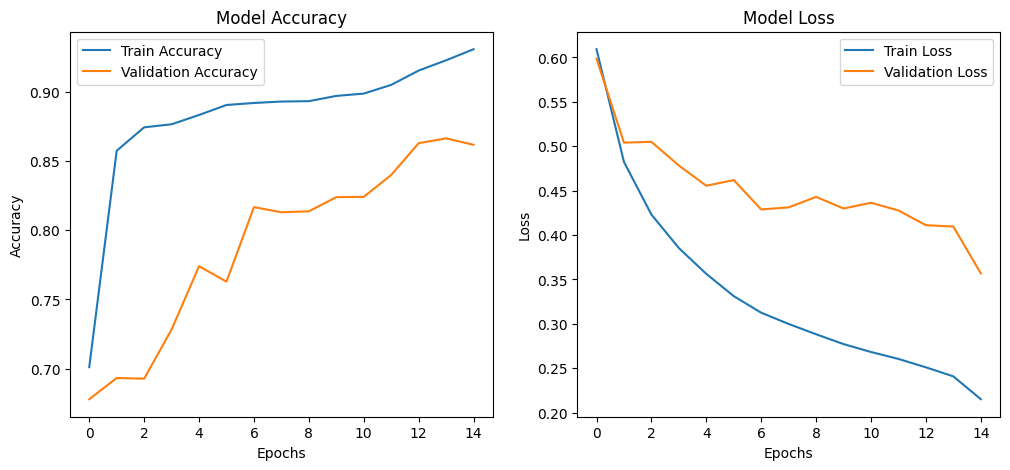

In [ ]:
# Plot Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)

In [ ]:
# Food Recommendation Function
def recommend_foods(available_ingredients, allergic_ingredients, top_n=3):
    input_seq = tokenizer.texts_to_sequences([" ".join(available_ingredients)])
    input_seq = pad_sequences(input_seq, maxlen=max_len)

    filtered_df = df.copy()
    filtered_df = filtered_df[~filtered_df["ingredients"].apply(lambda ing: any(allergic in ing for allergic in allergic_ingredients))]

    if filtered_df.empty:
        return "No matching ingredients found in the database. Please try different ingredients."

    filtered_df["ingredient_text"] = filtered_df["ingredients"].apply(lambda ing: " ".join(ing))
    filtered_sequences = tokenizer.texts_to_sequences(filtered_df["ingredient_text"])
    filtered_sequences = pad_sequences(filtered_sequences, maxlen=max_len)

    similarities = siamese_model.predict([np.tile(input_seq, (len(filtered_sequences), 1)), filtered_sequences]).flatten()

    importance_scores = np.array([sum(1 for ing in available_ingredients if ing in row) for row in filtered_df["ingredients"]])
    weighted_similarities = similarities + (0.5 * importance_scores / max(importance_scores, default=1))

    top_indices = weighted_similarities.argsort()[-top_n:][::-1]
    recommended_menus = filtered_df.iloc[top_indices][["en_name", "th_name", "ingredients"]]

    return recommended_menus

In [ ]:
# Test the model
if __name__ == "__main__":
    sample_available_ingredients = ["rice","meat"]
    sample_allergic_ingredients = ["herbs"]

    recommendations = recommend_foods(sample_available_ingredients, sample_allergic_ingredients)
    print("Recommended Menus:")
    print(recommendations)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Recommended Menus:
        en_name    th_name                   ingredients
259     Biryani    ข้าวหมก  [rice, spices, meat, yogurt]
34     Kao Maew    ข้าวแมว              [rice, mackerel]
174  Kraya Sadt  กระยาสารท        [rice, peanuts, sugar]


#Test Model

In [11]:
import pickle
import numpy as np
import pandas as pd
from ast import literal_eval
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# load dataset
def load_data():
    file_path = "/content/cleaned1_thailand_foods.csv"  # ปรับ path ให้ตรงกับไฟล์จริง
    df = pd.read_csv(file_path)
    df["ingredients"] = df["ingredients"].apply(literal_eval)  # แปลง string -> list
    df["ingredient_text"] = df["ingredients"].apply(lambda ing: " ".join(ing))  # แปลงเป็นข้อความ
    return df

df = load_data()

# load Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["ingredient_text"])  # Fit tokenizer กับ dataset จริง
sequences = tokenizer.texts_to_sequences(df["ingredient_text"])
max_len = max(map(len, sequences))  # หาความยาวสูงสุดของ sequence
x_data = pad_sequences(sequences, maxlen=max_len)

# load model
custom_objects = {'AttentionLayer': AttentionLayer, 'euclidean_distance': euclidean_distance}
siamese_model = load_model('/content/siamese_food_recommendation_model.h5', compile=False, custom_objects=custom_objects)

def recommend_foods(available_ingredients, allergic_ingredients=[], top_n=3):
    """
    ใช้โมเดลเปรียบเทียบวัตถุดิบกับเมนูใน dataset จริง และแนะนำเมนูที่ใกล้เคียงที่สุด

    Parameters:
    - available_ingredients (list): รายชื่อวัตถุดิบที่มี เช่น ["rice", "chicken"]
    - allergic_ingredients (list): รายชื่อวัตถุดิบที่แพ้ (เมนูที่มีส่วนผสมเหล่านี้จะถูกกรองออก)
    - top_n (int): จำนวนเมนูที่ต้องการให้โมเดลแนะนำ

    Returns:
    - DataFrame ของเมนูที่แนะนำ (เรียงตามค่าความคล้าย)
    """

    input_text = " ".join(available_ingredients)
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len)

    # เมนูที่มีส่วนผสมที่ไม่ต้องการจะถูกกรองออก
    filtered_df = df[~df["ingredients"].apply(lambda ing: any(allergic in ing for allergic in allergic_ingredients))]

    if filtered_df.empty:
        return "No suitable menus found. Try different ingredients."

    filtered_sequences = tokenizer.texts_to_sequences(filtered_df["ingredient_text"])
    filtered_sequences = pad_sequences(filtered_sequences, maxlen=max_len)

    # โมเดล Siamese คำนวณ similarity ระหว่าง input กับเมนูใน dataset
    similarities = siamese_model.predict([np.tile(input_seq, (len(filtered_sequences), 1)), filtered_sequences]).flatten()

    importance_scores = np.array([sum(1 for ing in available_ingredients if ing in row) for row in filtered_df["ingredients"]])
    weighted_similarities = similarities + (0.5 * importance_scores / max(importance_scores, default=1))

    top_indices = weighted_similarities.argsort()[-top_n:][::-1]
    recommended_menus = filtered_df.iloc[top_indices][["en_name", "th_name", "ingredients"]]

    return recommended_menus

sample_available_ingredients = ["rice", "chicken"]
sample_allergic_ingredients = ["peanuts"]

recommendations = recommend_foods(sample_available_ingredients, sample_allergic_ingredients, top_n=3)

print("Recommended Menus:")
print(recommendations)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Recommended Menus:
      en_name  th_name                   ingredients
34   Kao Maew  ข้าวแมว              [rice, mackerel]
259   Biryani  ข้าวหมก  [rice, spices, meat, yogurt]
237  Kai Jo     ไก่จ๊อ         [chicken, flour, egg]
